In [5]:
import win32com.client
import pythoncom
import os, sys, time
import inspect

import sqlite3

import pandas as pd
from pandas import DataFrame, Series, Panel

In [29]:
class XASessionEvents:
    상태= False
    
    def OnLogin(self, code, msg):        
        print('OnLogin: ', code, msg)
        XASessionEvents.상태= True

    def OnLogout(self):
        pass
    
    def OnDisconnect(self):
        pass   
    
    
class XAQueryEvents:
    상태= False
    
    def OnReceiveData(self, szTrCode):
        print('OnReceiveData: %s' % szTrCode)
        XAQueryEvents.상태= True
        
    def OnReceiveMessage(self, systemError, messageCode, message):
        print('OnReceiveMessage: ', systemError, messageCode, message)
        
        


In [7]:
def Login(url='demo.ebestsec.co.kr', port=20001, svrtype=0, id='userid', pwd='password', cert= '공인인증서'):
    session= win32com.client.DispatchWithEvents('XA_Session.XASession', XASessionEvents) # 객체생성
    session.SetMode('_XINGAPI7_', 'TRUE') # ????
    result= session.ConnectServer(url, port) # 서버접속
    
    # 서버접속 확인
    if not result:
        nErrCode= session.GetLastError()
        strErrMsg= session.GetErrorMessage(nErrCode)
        return (False, nErrCode, strErrMsg, None, session)
    
    # 로그인
    session.Login(id, pwd, cert, svrtype, 0)
    
      
    while XASessionEvents.상태== False:
        pythoncom.PumpWaitingMessages()
        
    # 계좌확인    
    계좌= []
    계좌수= session.GetAccountListCount()
    
    for i in range(계좌수):
        계좌.append(session.GetAccountList(i))
    
    return (True, 0, 'OK', 계좌, session)
        

In [8]:
# 주식종목조회 t8430, t8436
def t8430(구분='0'):
    
    query= win32com.client.DispatchWithEvents('XA_DataSet.XAQuery', XAQueryEvents)
    pathname= os.path.dirname(sys.argv[0])
    RESDIR= os.path.abspath(pathname)
    MYNAME= inspect.currentframe().f_code.co_name
    INBLOCK= '%sInBlock' % MYNAME
    OUTBLOCK= '%sOutBlock' % MYNAME
    OUTBLOCK1= '%sOutBlock1' % MYNAME
    #RESFILE= '%s\\Res\\%s.res' % (RESDIR, MYNAME)
    RESFILE= 'C:\\eBEST\\xingAPI\\Res\\%s.res' %(MYNAME)
    
    query.LoadFromResFile(RESFILE)
    query.SetFieldData(INBLOCK, 'gubun', 0, 구분)
    query.Request(0)

    while XAQueryEvents.상태== False:
        pythoncom.PumpWaitingMessages()
        
    result=[]
    nCount= query.GetBlockCount(OUTBLOCK)
    for i in range(nCount):
        종목명 = query.GetFieldData(OUTBLOCK, 'hname', i).strip() # 처음과 마지막 문자열에서 공백을 지운다. 
        단축코드 = query.GetFieldData(OUTBLOCK, "shcode", i).strip()
        확장코드 = query.GetFieldData(OUTBLOCK, "expcode", i).strip()
        ETF구분 = int(query.GetFieldData(OUTBLOCK, "etfgubun", i).strip())
        상한가 = int(query.GetFieldData(OUTBLOCK, "uplmtprice", i).strip())
        하한가 = int(query.GetFieldData(OUTBLOCK, "dnlmtprice", i).strip())
        전일가 = int(query.GetFieldData(OUTBLOCK, "jnilclose", i).strip())
        주문수량단위 = int(query.GetFieldData(OUTBLOCK, "memedan", i).strip())
        기준가 = int(query.GetFieldData(OUTBLOCK, "recprice", i).strip())
        구분 = int(query.GetFieldData(OUTBLOCK, 'gubun', i).strip()) #1: 코스피, 2: 코스닥
        
        lst=[종목명, 단축코드, 확장코드, ETF구분, 상한가, 하한가, 전일가, 주문수량단위, 기준가, 구분]
        result.append(lst)
        
    XAQueryEvents.상태= False
    
    columns=['종목명','단축코드','확장코드','ETF구분','상한가','하한가','전일가',
             '주문수량단위','기준가','구분']
    df = DataFrame(data=result, columns=columns)
    
    return df 


In [9]:
# 주식분별주가조회 t1302
# 주식시간대별체결조회 t1308

# 주식기간별주가조회 t1305
def t1305(단축코드='', 일주월구분='1', 날짜='', IDX='', 건수='900', 연속조회= False):
    
    query= win32com.client.DispatchWithEvents('XA_DataSet.XAQuery', XAQueryEvents)    
    pathname= os.path.dirname(sys.argv[0])
    RESDIR= os.path.abspath(pathname)
    MYNAME= inspect.currentframe().f_code.co_name
    INBLOCK= '%sInBlock' % MYNAME
    OUTBLOCK= '%sOutBlock' % MYNAME
    OUTBLOCK1= '%sOutBlock1' % MYNAME
    #RESFILE= '%s\\Res\\%s.res' % (RESDIR, MYNAME)
    RESFILE= 'C:\\eBEST\\xingAPI\\Res\\%s.res' %(MYNAME)
    
    query.LoadFromResFile(RESFILE)
    
    if 연속조회 == False:
        query.SetFieldData(INBLOCK, 'shcode', 0, 단축코드)
        query.SetFieldData(INBLOCK, 'dwmcode', 0, 일주월구분)
        query.SetFieldData(INBLOCK, 'date', 0, 날짜)    
        query.SetFieldData(INBLOCK, 'idx', 0, IDX)    
        query.SetFieldData(INBLOCK, 'cnt', 0, 건수)
        query.Request(0) # 0:조회, 1:다음조회
    else:
        print('연속조회 요청', 날짜)
        query.SetFieldData(INBLOCK, 'shcode', 0, 단축코드)
        query.SetFieldData(INBLOCK, 'dwmcode', 0, 일주월구분)
        query.SetFieldData(INBLOCK, 'date', 0, 날짜)    
        query.SetFieldData(INBLOCK, 'idx', 0, IDX)    
        query.SetFieldData(INBLOCK, 'cnt', 0, 건수)
        query.Request(1) # 0:조회, 1:다음조회
    
    while XAQueryEvents.상태== False:
        pythoncom.PumpWaitingMessages()
        
    result=[]
    nCount= query.GetBlockCount(OUTBLOCK)
    for i in range(nCount):
        CNT = int(query.GetFieldData(OUTBLOCK, "cnt", i).strip())
        날짜 = query.GetFieldData(OUTBLOCK, "date", i).strip()
        IDX = int(query.GetFieldData(OUTBLOCK, "idx", i).strip())        
        lst= [CNT, 날짜, IDX]
        result.append(lst)
        
    df= DataFrame(data=result, columns=['CNT','날짜','IDX'])
    
    result = []
    nCount = query.GetBlockCount(OUTBLOCK1)    
    
    for i in range(nCount):
        날짜 = query.GetFieldData(OUTBLOCK1, "date", i).strip()
        시가 = int(query.GetFieldData(OUTBLOCK1, "open", i).strip())
        고가 = int(query.GetFieldData(OUTBLOCK1, "high", i).strip())
        저가 = int(query.GetFieldData(OUTBLOCK1, "low", i).strip())
        종가 = int(query.GetFieldData(OUTBLOCK1, "close", i).strip())
        전일대비구분 = query.GetFieldData(OUTBLOCK1, "sign", i).strip()
        전일대비 = int(query.GetFieldData(OUTBLOCK1, "change", i).strip())
        등락율 = float(query.GetFieldData(OUTBLOCK1, "diff", i).strip())
        누적거래량 = int(query.GetFieldData(OUTBLOCK1, "volume", i).strip())
        거래증가율 = float(query.GetFieldData(OUTBLOCK1, "diff_vol", i).strip())
        체결강도 = float(query.GetFieldData(OUTBLOCK1, "chdegree", i).strip())
        소진율 = float(query.GetFieldData(OUTBLOCK1, "sojinrate", i).strip())
        회전율 = float(query.GetFieldData(OUTBLOCK1, "changerate", i).strip())
        외인순매수 = int(query.GetFieldData(OUTBLOCK1, "fpvolume", i).strip()) # 순매매량
        기관순매수 = int(query.GetFieldData(OUTBLOCK1, "covolume", i).strip())
        종목코드 = query.GetFieldData(OUTBLOCK1, "shcode", i).strip()
        누적거래대금 = int(query.GetFieldData(OUTBLOCK1, "value", i).strip()) # 단위:백만
        개인순매수 = int(query.GetFieldData(OUTBLOCK1, "ppvolume", i).strip())
#         시가대비구분 = query.GetFieldData(OUTBLOCK1, "o_sign", i).strip()
#         시가대비 = int(query.GetFieldData(OUTBLOCK1, "o_change", i).strip())
#         시가기준등락율 = float(query.GetFieldData(OUTBLOCK1, "o_diff", i).strip())
#         고가대비구분 = query.GetFieldData(OUTBLOCK1, "h_sign", i).strip()
#         고가대비 = int(query.GetFieldData(OUTBLOCK1, "h_change", i).strip())
#         고가기준등락율 = float(query.GetFieldData(OUTBLOCK1, "h_diff", i).strip())
#         저가대비구분 = query.GetFieldData(OUTBLOCK1, "l_sign", i).strip()
#         저가대비 = int(query.GetFieldData(OUTBLOCK1, "l_change", i).strip())
#         저가기준등락율 = float(query.GetFieldData(OUTBLOCK1, "l_diff", i).strip())
        시가총액 = int(query.GetFieldData(OUTBLOCK1, "marketcap", i).strip()) # 단위:백만
        
        lst = [날짜,시가,고가,저가,종가,전일대비구분,전일대비,등락율,누적거래량,누적거래대금,거래증가율,
               체결강도,소진율,회전율,외인순매수,기관순매수,개인순매수,종목코드,시가총액]
        result.append(lst)
        #lst = [날짜,시가,고가,저가,종가,전일대비구분,전일대비,등락율,누적거래량,거래증가율,체결강도,소진율,회전율,외인순매수,기관순매수,종목코드,누적거래대금,개인순매수,시가대비구분,시가대비,시가기준등락율,고가대비구분,고가대비,고가기준등락율,저가대비구분,저가대비,저가기준등락율,시가총액]
    
    
    df1= DataFrame(data=result, 
                   columns=['날짜','시가','고가','저가','종가','구분','전일대비','등락율',
                            '누적거래량','누적거래대금','거래증가율','체결강도','소진율','회전율',
                            '외인순매수','기관순매수','개인순매수','종목코드','시가총액'])
    XAQueryEvents.상태 = False
    return (df, df1)   
    
    

In [10]:
# 차트지표데이터 ChartIndex

def ChartIndex(지표ID='',지표명='',지표조건설정='',시장구분='1',주기구분='2',단축코드='',요청건수='500',
               단위='',시작일자='',종료일자='',수정주가반영여부='1',갭보정여부='1',
               실시간데이터수신자동등록여부='0'):
            
    query= win32com.client.DispatchWithEvents('XA_DataSet.XAQuery', XAQueryEvents)    
    pathname= os.path.dirname(sys.argv[0])
    RESDIR= os.path.abspath(pathname)
    MYNAME= inspect.currentframe().f_code.co_name
    INBLOCK= '%sInBlock' % MYNAME
    OUTBLOCK= '%sOutBlock' % MYNAME
    OUTBLOCK1= '%sOutBlock1' % MYNAME
    #RESFILE= '%s\\Res\\%s.res' % (RESDIR, MYNAME)
    RESFILE= 'C:\\eBEST\\xingAPI\\Res\\%s.res' %(MYNAME)
    
    
    query.LoadFromResFile(RESFILE)
    query.SetFieldData(INBLOCK, "indexid", 0, 지표ID)
    query.SetFieldData(INBLOCK, "indexname", 0, 지표명)
    query.SetFieldData(INBLOCK, "indexparam", 0, 지표조건설정)
    query.SetFieldData(INBLOCK, "market", 0, 시장구분)
    query.SetFieldData(INBLOCK, "period", 0, 주기구분)
    query.SetFieldData(INBLOCK, "shcode", 0, 단축코드)
    query.SetFieldData(INBLOCK, "qrycnt", 0, 요청건수)
    query.SetFieldData(INBLOCK, "ncnt", 0, 단위)
    query.SetFieldData(INBLOCK, "sdate", 0, 시작일자)
    query.SetFieldData(INBLOCK, "edate", 0, 종료일자)
    query.SetFieldData(INBLOCK, "Isamend", 0, 수정주가반영여부)
    query.SetFieldData(INBLOCK, "Isgab", 0, 갭보정여부)
    query.SetFieldData(INBLOCK, "IsReal", 0, 실시간데이터수신자동등록여부)
    query.RequestService("ChartIndex", "")
    
    
    while XAQueryEvents.상태== False:
        pythoncom.PumpWaitingMessages()
    
    result=[]
    nCount = query.GetBlockCount(OUTBLOCK)
    for i in range(nCount):
        지표ID = int(query.GetFieldData(OUTBLOCK, "indexid", i).strip())
        레코드갯수 = int(query.GetFieldData(OUTBLOCK, "rec_cnt", i).strip())
        유효데이터컬럼갯수 = int(query.GetFieldData(OUTBLOCK, "validdata_cnt", i).strip())       
        lst= [지표ID, 레코드갯수, 유효데이터컬럼갯수]
        result.append(lst)
        
    df= DataFrame(data=result, columns=['지표ID','레코드갯수','유효데이터컬럼갯수'])

    result = []
    nCount = query.GetBlockCount(OUTBLOCK1)
    for i in range(nCount):
        일자 = query.GetFieldData(OUTBLOCK1, "date", i).strip()
        시간 = query.GetFieldData(OUTBLOCK1, "time", i).strip()
        시가 = float(query.GetFieldData(OUTBLOCK1, "open", i).strip())
        고가 = float(query.GetFieldData(OUTBLOCK1, "high", i).strip())
        저가 = float(query.GetFieldData(OUTBLOCK1, "low", i).strip())
        종가 = float(query.GetFieldData(OUTBLOCK1, "close", i).strip())
        거래량 = float(query.GetFieldData(OUTBLOCK1, "volume", i).strip())
        지표값1 = float(query.GetFieldData(OUTBLOCK1, "value1", i).strip())
        지표값2 = float(query.GetFieldData(OUTBLOCK1, "value2", i).strip())
        지표값3 = float(query.GetFieldData(OUTBLOCK1, "value3", i).strip())
        지표값4 = float(query.GetFieldData(OUTBLOCK1, "value4", i).strip())
        지표값5 = float(query.GetFieldData(OUTBLOCK1, "value5", i).strip())
        위치 = int(query.GetFieldData(OUTBLOCK1, "pos", i).strip())

        lst = [일자, 시간, 시가, 고가, 저가, 종가, 거래량, 지표값1, 지표값2, 지표값3, 지표값4, 지표값5]
        result.append(lst)

    columns = ['일자', '시간', '시가', '고가', '저가', '종가', '거래량', '지표값1', '지표값2', '지표값3', '지표값4', '지표값5']
    df1 = DataFrame(data=result, columns=columns)
    XAQueryEvents.상태 = False
    return (df, df1)


In [63]:
#처음조회
cn, df0= ChartIndex(지표ID='', 지표명='RSI', 지표조건설정='', 시장구분='1', 주기구분='2', 단축코드='005930', 
                    요청건수='500',단위='',시작일자='',종료일자='', 수정주가반영여부='1', 갭보정여부='1',
                    실시간데이터수신자동등록여부='0')

OnReceiveMessage:  0 00000 조회완료
OnReceiveData: CHARTINDEX


In [44]:
# 다음 종료일자 찾기
for 


'20170118'

In [59]:
#다음조회
cn, df0= ChartIndex(지표ID='', 지표명='RSI', 지표조건설정='', 시장구분='1', 주기구분='2', 단축코드='005930', 
                    요청건수='500',단위='',시작일자='',종료일자='20171231', 수정주가반영여부='1', 갭보정여부='1',
                    실시간데이터수신자동등록여부='0')

OnReceiveMessage:  0 00000 조회완료
OnReceiveData: CHARTINDEX


In [65]:
print(df0.shape)
df0.head()

(501, 12)


,일자,시간,시가,고가,저가,종가,거래량,지표값1,지표값2,지표값3,지표값4,지표값5
0,일자,시간,0.0,0.0,0.0,0.0,0.0,14.0,9.0,0.0,0.0,0.0
1,20170118,090000,37040.0,37500.0,36620.0,36940.0,177508.0,0.0,0.0,0.0,0.0,0.0
2,20170119,090000,37720.0,37920.0,37020.0,37480.0,188378.0,0.0,0.0,0.0,0.0,0.0
3,20170120,090000,37120.0,37420.0,36880.0,37200.0,183700.0,0.0,0.0,0.0,0.0,0.0
4,20170123,090000,37200.0,38060.0,37000.0,38060.0,176208.0,0.0,0.0,0.0,0.0,0.0


In [67]:
df0.tail()

,일자,시간,시가,고가,저가,종가,거래량,지표값1,지표값2,지표값3,지표값4,지표값5
496,20190130,090000,44800.0,46400.0,44800.0,46400.0,17505980.0,77.11,68.59,0.0,0.0,0.0
497,20190131,090000,46650.0,47050.0,46150.0,46150.0,21621145.0,74.79,69.83,0.0,0.0,0.0
498,20190201,090000,46650.0,46950.0,46250.0,46350.0,13832454.0,75.43,70.95,0.0,0.0,0.0
499,20190207,090000,46800.0,47100.0,46200.0,46200.0,15872001.0,73.92,71.55,0.0,0.0,0.0
500,20190208,090000,45700.0,45700.0,44650.0,44800.0,12689196.0,61.57,69.55,0.0,0.0,0.0


In [30]:
# 계좌정보 = pd.read_csv("secret/passwords.csv", converters={'계좌번호': str, '거래비밀번호': str})
# 주식계좌정보 = 계좌정보.query("구분 == '거래'")
# if len(주식계좌정보) == 0:
#     print("secret디렉토리의 passwords.csv 파일에서 거래 계좌를 지정해 주세요")
# else:
#     계좌번호 = 주식계좌정보['계좌번호'].values[0].strip()
#     id = 주식계좌정보['사용자ID'].values[0].strip()
#     pwd = 주식계좌정보['비밀번호'].values[0].strip()
#     cert = 주식계좌정보['공인인증비밀번호'][0].strip()
#     거래비밀번호 = 주식계좌정보['거래비밀번호'].values[0].strip()
#     url = 주식계좌정보['url'][0].strip()

계좌번호= '555-01-032827' # 모의투자 계좌번호
id= 'dowaari' 
pwd= '10805a' 
cert= '공인인증서'
거래비밀번호= 0000
url= 'demo.ebestsec.co.kr'

# 계좌번호= '202072097-01' # 실투자 계좌번호
# id= 'dowaari' 
# pwd= '108051a!' 
# cert= 'dowaari0070a!'
# 거래비밀번호= 1080
# url= 'hts.ebestsec.co.kr'


result, code, msg, 계좌, session = Login(url=url, port=200001, svrtype=0,id=id, pwd=pwd,cert=cert)
if result == False:
    print('result: False')
    sys.exit(0)

OnLogin:  0000 로그인 성공


In [28]:
계좌

[]

In [8]:
# 주식분별주가조회 t1302 미사용
# 주식시간대별체결조회 t1308 미사용
# 주식기간별주가조회 t1305(수정주가미반영), t8413(수정주가반영), t4201 (수정주가반영)
# 주식종목조회 t8430, t8436
# 외인기관종목별동향 t1702, t1717
# 차트지표데이터 ChartIndex (수정주가반영)




In [9]:
# 업데이트 방식 , 하루에 한번씩
# 업데이트 또는 다운로드실행 마지막날짜 저장 -> 현재날짜와 비교 -> 건수계산
# 계산된 건수가 0이더라도 무조건 현재날짜는 업데이트한다. (무조건 건수1)
# 건수10 -> 현재df 과거df 를 합친다. (시간인덱스 교집합)
# 2800/200= 14회*10분 =140분
#
# 모델학습->모델적용->벡테스팅(은 기존 상용프로그램으로 사용가능?)

# 한달에 한번씩
# 모델학습

# 수정주가 반영관련
# (주가*거래량) / 수정주가 = 수정거래량
# (주가*기관거래량) / 수정주가 = 수정기관거래량



In [49]:
# 대신증권은 15초에 60건 초과 
# 키움증권은 1초에 5건, 1분에 100건, 1시간에 1000건
# 1번에 최대 1000개, 1초당 1건, 10분당 200건 (TR제한 3.3초에 1건)
# 2006년부터 3000개를 조회한다. 900*3=2700, 3회 -> 코스피200종목 *3= 600 이니까 30분걸림.

cn, df0= t1305(단축코드='005930', 일주월구분='1', 날짜='', IDX='', 건수='1000', 연속조회= False)

for i in range(3):
    time.sleep(1.5)
    df1= None
    cn, df1= t1305(단축코드='005930', 일주월구분='1', 날짜= cn['날짜'].values[0], 
                IDX='', 건수='1000', 연속조회= True)
    df0 = pd.concat([df0, df1])
    
df0.reset_index(inplace= True)
df0.drop('index', axis=1, inplace= True)

# with sqlite3.connect('./data/Darjeeling.sqlite') as conn:
#     df.to_sql('기간별주가', con=conn, if_exists='replace', index= False) # if_exists='append'

OnReceiveMessage:  0 00000 조회완료
OnReceiveData: t1305
연속조회 요청 20150112
OnReceiveMessage:  0 00000 조회완료
OnReceiveData: t1305
연속조회 요청 20101223
OnReceiveMessage:  0 00000 조회완료
OnReceiveData: t1305
연속조회 요청 20061218
OnReceiveMessage:  0 00000 조회완료
OnReceiveData: t1305


In [50]:
print(df0.shape)
df0.head()

(4000, 19)


,날짜,시가,고가,저가,종가,전일대비구분,전일대비,등락율,누적거래량,누적거래대금,거래증가율,체결강도,소진율,회전율,외인순매수,기관순매수,개인순매수,종목코드,시가총액
0,20190208,45700,45700,44650,44800,5,1400,-3.03,12689196,571011,-20.05,60.05,56.64,0.21,-1338132,680004,769108,005930,267446258
1,20190207,46800,47100,46200,46200,5,150,-0.32,15872001,739207,14.74,94.46,56.69,0.27,1420917,-1253036,-104471,005930,275803954
2,20190201,46650,46950,46250,46350,2,200,0.43,13832454,644180,-36.02,74.05,56.67,0.23,2973755,-1177459,-1739435,005930,276699421
3,20190131,46650,47050,46150,46150,5,250,-0.54,21621145,1007418,23.51,67.02,56.62,0.36,5634958,-3405576,-2179479,005930,275505465
4,20190130,44800,46400,44800,46400,2,900,1.98,17505980,802320,7.96,120.69,56.49,0.29,4247073,-572520,-3530947,005930,276997910


In [57]:
df0[:500].tail()


,날짜,시가,고가,저가,종가,전일대비구분,전일대비,등락율,누적거래량,누적거래대금,거래증가율,체결강도,소진율,회전율,외인순매수,기관순매수,개인순매수,종목코드,시가총액
495,20170124,1906000,1929000,1894000,1908000,2,5000,0.26,220975,421544,25.41,143.39,50.69,0.16,-22336,24778,-2384,005930,268416175
496,20170123,1860000,1903000,1850000,1903000,2,43000,2.31,176208,331204,-4.08,167.96,50.69,0.13,8109,689,-8236,005930,267712778
497,20170120,1856000,1871000,1844000,1860000,5,14000,-0.75,183700,341612,-2.48,117.01,50.71,0.13,-35908,22752,13141,005930,261663567
498,20170119,1886000,1896000,1851000,1874000,2,27000,1.46,188378,352855,6.12,98.95,50.73,0.13,9030,-41349,31039,005930,263633078
499,20170118,1852000,1875000,1831000,1847000,5,1000,-0.05,177508,328696,8.89,112.80,50.72,0.13,-24321,16320,8076,005930,259834735


In [15]:
data['date']= pd.to_datetime(data['날짜'].values)

In [16]:
data.query(" '20180301' < 날짜 < '20180601' ")

,날짜,시가,고가,저가,종가,전일대비구분,전일대비,등락율,누적거래량,누적거래대금,거래증가율,체결강도,소진율,회전율,외인순매수,기관순매수,개인순매수,종목코드,시가총액,date
167,20180531,50400,50800,49850,50700,2,1200,2.42,63491109,3160206,209.74,115.55,53.03,0.99,23134869,-23615581,406455,005930,325459762,2018-05-31
168,20180530,51300,51500,49100,49500,5,1800,-3.51,20498098,1026413,141.71,72.57,52.68,0.32,-4666036,-3692779,8279229,005930,317756573,2018-05-30
169,20180529,52200,52500,51300,51300,5,1000,-1.91,8480437,437715,-13.36,58.58,52.75,0.13,-326821,-1278312,1511572,005930,329311357,2018-05-29
170,20180528,52500,53000,52000,52300,5,400,-0.76,9787820,513194,-35.64,92.42,52.75,0.15,64259,310922,-391647,005930,335730682,2018-05-28
171,20180525,51000,52800,50800,52700,2,1300,2.53,15207266,795151,83.46,194.05,52.75,0.24,4195935,743664,-4850610,005930,338298412,2018-05-25
172,20180524,52000,52000,51100,51400,5,400,-0.77,8289275,426264,-51.51,90.54,52.69,0.13,88853,-1620133,610552,005930,329953290,2018-05-24
173,20180523,50600,52000,50400,51800,2,1800,3.60,17095490,878627,89.51,205.07,52.70,0.27,867167,532182,-1694629,005930,332521019,2018-05-23
174,20180521,49650,50200,49100,50000,2,500,1.01,9020998,449245,34.51,101.27,52.69,0.14,219443,356815,-702126,005930,320966235,2018-05-21
175,20180518,49900,49900,49350,49500,2,100,0.20,6706570,332487,-35.30,104.29,52.69,0.10,-552339,112622,422922,005930,317756573,2018-05-18
176,20180517,50300,50500,49400,49400,5,450,-0.90,10365440,515599,-34.89,67.60,52.70,0.16,-2350567,751607,1566167,005930,317114640,2018-05-17


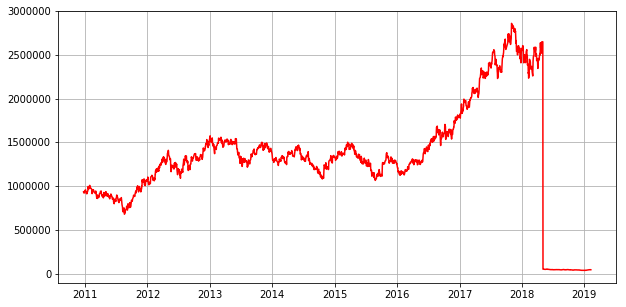

In [83]:
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(10,5))
ax1= fig.add_subplot(1,1,1)
ax1.plot(data['date'], data['종가'], color='r')
plt.grid()
plt.show()

# f,ax= plt.subplots(1,2, figsize=(10,5))
# data.groupby(['Initial'])['Age'].mean().plot.bar(ax=ax[0])


,CNT,날짜,IDX
0,1000,20150112,0


In [19]:
df= t8430(구분='0') # 구분 0:전체, 1:코스피, 2:코스닥
with sqlite3.connect('./data/Darjeeling.sqlite') as conn:
    df.to_sql('종목코드', con=conn, if_exists='replace', index= False) # if_exists='append'


OnReceiveMessage:  0 00000 조회완료
OnReceiveData: t8430


In [22]:
print(df.shape)
df.head()


(2851, 10)


,종목명,단축코드,확장코드,ETF구분,상한가,하한가,전일가,주문수량단위,기준가,구분
0,동화약품,000020,KR7000020008,0,12750,6890,9840,1,9840,1
1,우리은행,000030,KR7000030007,0,19200,10400,14800,1,14800,1
2,KR모터스,000040,KR7000040006,0,691,373,532,1,532,1
3,경방,000050,KR7000050005,0,14350,7750,11050,1,11050,1
4,메리츠화재,000060,KR7000060004,0,29600,16000,22800,1,22800,1


In [23]:
df.tail()

,종목명,단축코드,확장코드,ETF구분,상한가,하한가,전일가,주문수량단위,기준가,구분
2846,SBI핀테크솔루션즈,950110,KR8392070007,0,16800,9100,12950,1,12950,2
2847,엑세스바이오,950130,KR8840090003,0,5180,2795,3990,1,3990,2
2848,잉글우드랩,950140,KR8840110108,0,6990,3770,5380,1,5380,2
2849,코오롱티슈진,950160,KR8840120008,0,50500,27200,38850,1,38850,2
2850,JTC,950170,KR8392080006,0,9330,5030,7180,1,7180,2


In [32]:
print(df[df['구분']==1].shape)
print(df[df['구분']==2].shape)

(1524, 10)
(1327, 10)
